<a href="https://colab.research.google.com/github/nicolesaade/WorldHappinessReportAnalysis/blob/main/WorldHappinessReport_Time_Series_4(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3. Predict 2023-29 Life Ladder

##3(a) Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

##3(b) Load Life Ladder Score



In [2]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load data
data = pd.read_csv('happiness_dataset.csv')

# Normalize data
scaler = StandardScaler()
data['Life Ladder'] = scaler.fit_transform(data[['Life Ladder']])

# Dataframe with life ladder score 2018-2023
ladder_data = data[['Country name', 'year', 'Life Ladder']].loc[data['year'].isin([2018, 2019, 2020, 2021, 2022, 2023])]

# Remove countries missing any of the 2018-2023 life ladder scores
countries = set(ladder_data.loc[ladder_data['year']==2018]['Country name'].unique()).intersection(
    ladder_data.loc[ladder_data['year']==2019]['Country name'].unique(),
    ladder_data.loc[ladder_data['year']==2020]['Country name'].unique(),
    ladder_data.loc[ladder_data['year']==2021]['Country name'].unique(),
    ladder_data.loc[ladder_data['year']==2022]['Country name'].unique(),
    ladder_data.loc[ladder_data['year']==2023]['Country name'].unique()
)
ladder_data = ladder_data.loc[ladder_data['Country name'].isin(countries)]

# Show all the countries using df.head()
ladder_data.head(-1)

,Country name,year,Life Ladder
25,Albania,2018,-0.426173
26,Albania,2019,-0.434171
27,Albania,2020,-0.105365
28,Albania,2021,-0.203118
29,Albania,2022,-0.241331
...,...,...,...
2357,Zimbabwe,2018,-1.659641
2358,Zimbabwe,2019,-2.478990
2359,Zimbabwe,2020,-2.064872
2360,Zimbabwe,2021,-2.069315


Visualize Life Ladder Score Trajectory

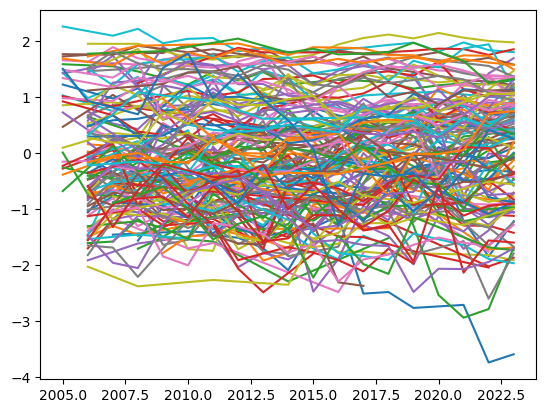

In [ ]:
import matplotlib.pyplot as plt

for country in data['Country name'].unique():
  plt.plot(data.loc[data['Country name']==country]['year'], data.loc[data['Country name']==country]['Life Ladder'])

##3(c) LSTM 1 (no linear regression)

In [3]:
predictions1 = {}
for country in countries:
    country_data = ladder_data.loc[ladder_data['Country name']==country]

    X = country_data['Life Ladder'].values.reshape(-1, 1)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X[:-1], X[:-1], epochs=100, verbose=0) #train model with 2018-2022 data

    last_ladder = X[-2] #2022 data
    forecast = [] #stores Predicted 2023-29 data
    for _ in range(6):
        lstm_preds = model.predict(last_ladder.reshape(-1, 1))
        forecast.append(lstm_preds[0,0])
        last_ladder = lstm_preds[0,0]

    predictions1[country] = forecast

1/1 [==============================] - 0s 22ms/step


In [21]:
p1_df = pd.DataFrame.from_dict(predictions1, orient='index', columns=['Pred 2023', 'Pred 2024', 'Pred 2025', 'Pred 2026', 'Pred 2027', 'Pred 2028'])

true_2023 = []
R2_score = []
for country in p1_df.index:
  y_true = ladder_data.loc[(ladder_data['Country name'] == country) & (ladder_data['year'] == 2023), 'Life Ladder'].values[0]
  y_pred = p1_df['Pred 2023'][country]
  true_2023.append(y_true)
  R2_score.append((y_true-y_pred)**2)

p1_df['True 2023'] = true_2023
p1_df['R^2 Score'] = R2_score

p1_df.head()

from google.colab import drive
#!pip install pandas==2.0
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/DS Group Project/'
p1_df.to_csv(path+'p1.csv', index=False)

Mounted at /content/drive


##3(d) LSTM 2 (combination of LSTM and Linear Regression)

In [40]:
predictions2 = {}
for country in countries:
    country_data = ladder_data.loc[ladder_data['Country name']==country]
    X = country_data['Life Ladder'].values.reshape(-1, 1)

    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, X_train, epochs=100, verbose=0)

    lstm_preds = model.predict(X_test)

    regressor = LinearRegression()
    regressor.fit(lstm_preds, X_test)

    last_ladder = X[-2] #2022 data
    forecast = [] #Predicted 2023-2029
    for _ in range(6):
        lstm_preds = model.predict(last_ladder.reshape(-1, 1))
        prediction = regressor.predict(lstm_preds)
        forecast.append(prediction[0,0])
        last_ladder = prediction

    predictions2[country] = forecast

1/1 [==============================] - 0s 26ms/step


In [41]:
p2_df = pd.DataFrame.from_dict(predictions2, orient='index', columns=['Pred 2023', 'Pred 2024', 'Pred 2025', 'Pred 2026', 'Pred 2027', 'Pred 2028'])

true_2023 = []
R2_score = []
for country in p2_df.index:
  y_true = ladder_data.loc[(ladder_data['Country name'] == country) & (ladder_data['year'] == 2023), 'Life Ladder'].values[0]
  y_pred = p2_df['Pred 2023'][country]
  true_2023.append(y_true)
  R2_score.append((y_true-y_pred)**2)

p2_df['True 2023'] = true_2023
p2_df['R^2 Score'] = R2_score

p2_df.head()
p2_df.to_csv(path+'p2.csv', index=False)

#3(f) Evaluation

In [22]:
from plotly import graph_objects as go

def display_results(predictions):
  # Calculate the happiness score increase/decrease and final happiness score for each country
  country_stats = []
  for country, forecast in predictions.items():
      initial_score = forecast[0]
      final_score = forecast[-1]
      change = final_score - initial_score
      country_stats.append((country, change, final_score))

  # Sort the countries based on the happiness score increase/decrease and final happiness score
  country_stats.sort(key=lambda x: (x[1], x[2]), reverse=True)

  # Create traces for each country's predicted happiness scores
  traces = []
  for country, _, _ in country_stats:
      predicted = pd.DataFrame({'Year': range(2023, 2029), 'Life Ladder': predictions[country]})
      trace = go.Scatter(x=predicted['Year'], y=predicted['Life Ladder'], mode='lines+markers', name=country)
      traces.append(trace)

  # Create the layout for the plot
  layout = go.Layout(
      title='Predicted Life Ladder for All Countries',
      xaxis=dict(title='Year'),
      yaxis=dict(title='Life Ladder'),
      hovermode='closest',
      width=800,
      height=600
  )

  # Create the figure and display the plot
  fig = go.Figure(data=traces, layout=layout)
  fig.show()

  # Print the ranking of countries based on happiness score increase/decrease and final happiness score
  print("Ranking of Countries:")
  for i, (country, change, final_score) in enumerate(country_stats, start=1):
      print(f"{i}. {country}: Increase/Decrease = {change:.4f}, Final Score = {final_score:.4f}")

In [42]:
display_results(predictions1)
display_results(predictions2)

Ranking of Countries:
1. Finland: Increase/Decrease = 1.3191, Final Score = 3.4275
2. Sweden: Increase/Decrease = 1.0764, Final Score = 2.9135
3. Lebanon: Increase/Decrease = 0.9607, Final Score = -1.7244
4. Zimbabwe: Increase/Decrease = 0.6766, Final Score = -0.9221
5. Bangladesh: Increase/Decrease = 0.5765, Final Score = -0.5832
6. Tanzania: Increase/Decrease = 0.5150, Final Score = -0.7568
7. Zambia: Increase/Decrease = 0.4096, Final Score = -0.9398
8. Egypt: Increase/Decrease = 0.2579, Final Score = -0.8724
9. Ghana: Increase/Decrease = 0.2441, Final Score = -0.5801
10. Austria: Increase/Decrease = 0.2139, Final Score = 1.6126
11. Germany: Increase/Decrease = 0.2054, Final Score = 1.2875
12. Ireland: Increase/Decrease = 0.2031, Final Score = 1.5031
13. Benin: Increase/Decrease = 0.1940, Final Score = -0.7706
14. Sri Lanka: Increase/Decrease = 0.1852, Final Score = -1.0565
15. Mali: Increase/Decrease = 0.1676, Final Score = -0.8706
16. Croatia: Increase/Decrease = 0.1433, Final Scor

Ranking of Countries:
1. Lithuania: Increase/Decrease = 7.5063, Final Score = 9.0408
2. Bulgaria: Increase/Decrease = 2.2963, Final Score = 2.2253
3. Vietnam: Increase/Decrease = 1.7418, Final Score = 2.5947
4. South Africa: Increase/Decrease = 1.6793, Final Score = 2.3016
5. Malaysia: Increase/Decrease = 1.4478, Final Score = 2.0314
6. Mexico: Increase/Decrease = 0.6897, Final Score = 2.1267
7. Israel: Increase/Decrease = 0.4938, Final Score = 2.4739
8. Poland: Increase/Decrease = 0.4905, Final Score = 1.5858
9. Serbia: Increase/Decrease = 0.4051, Final Score = 1.3868
10. Nicaragua: Increase/Decrease = 0.2703, Final Score = 1.1067
11. Venezuela: Increase/Decrease = 0.2552, Final Score = 0.8196
12. Switzerland: Increase/Decrease = 0.2039, Final Score = 1.5236
13. Pakistan: Increase/Decrease = 0.1925, Final Score = -0.2572
14. Russia: Increase/Decrease = 0.1478, Final Score = 0.6916
15. Japan: Increase/Decrease = 0.1462, Final Score = 0.7820
16. Estonia: Increase/Decrease = 0.1298, Fina

In [62]:
import plotly.graph_objects as go

scatter1 = go.Scatter(
    x=p1_df['True 2023'],
    y=p1_df['Pred 2023'],
    mode='markers',
    marker=dict(color='red', size=10),
    name='LSTM1')

scatter2 = go.Scatter(
    x=p2_df['True 2023'],
    y=p2_df['Pred 2023'],
    mode='markers',
    marker=dict(color='blue', size=10),
    name='LSTM2')

layout = go.Layout(
    title='True 2023 vs Predicted 2023',
    xaxis=dict(title='True 2023'),
    yaxis=dict(title='Predicted 2023'),
    width=800,
    height=800)

fig = go.Figure(data=[scatter1, scatter2], layout=layout)
fig.add_trace(go.Scatter(
        x=np.linspace(-2, 2, 400),
        y=np.linspace(-2, 2, 400),
        mode='lines',
        line=dict(color='black'),
        name='y=x'))

fig.show()


In [64]:
line_plot1 = go.Scatter(
    x=p1_df.index, # Assuming you want the index as the x-axis
    y=p1_df['R^2 Score'],
    mode='lines',
    line=dict(color='red'),
    name='LSTM1'
)

line_plot2 = go.Scatter(
    x=p2_df.index, # Assuming you want the index as the x-axis
    y=p2_df['R^2 Score'],
    mode='lines',
    line=dict(color='blue'),
    name='LSTM2'
)

layout = go.Layout(
    title='R^2 Score',
    xaxis=dict(title='Index'),
    yaxis=dict(title='R^2 Score')
)

fig = go.Figure(data=[line_plot1, line_plot2], layout=layout)
fig.show()
